In [ ]:
!pip install -q ultralytics tqdm lxml matplotlib albumentations torchvision

import os
import shutil
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image
import torchvision
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

In [ ]:
class Config:
    VOC_YEAR = "2012"
    VOC_ROOT = "./VOCdevkit/VOC2012"
    OUTPUT_ROOT = "./dataset"
    MODEL_TYPE = "yolov8n.pt"
    CLASSES = [
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
        'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]

Config.TRAINING_CONFIG = Config.TRAINING_CONFIG = {
    'data': "voc.yaml",
    'batch': 16,
    'imgsz': 640,
    'lr0': 0.001,
    'lrf': 0.02,
    'optimizer': "SGD",
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'epochs': 200,
    'augment': True,
    'verbose': True,
    'workers': 4,
    'patience': 15,
    'save': True
}



In [ ]:
def prepare_dataset():
    torchvision.datasets.VOCDetection(root=".", year=Config.VOC_YEAR, image_set="train", download=True)
    for dir_path in [f"{Config.OUTPUT_ROOT}/images/train", f"{Config.OUTPUT_ROOT}/images/val",
                     f"{Config.OUTPUT_ROOT}/labels/train", f"{Config.OUTPUT_ROOT}/labels/val"]:
        os.makedirs(dir_path, exist_ok=True)

prepare_dataset()


100%|██████████| 2.00G/2.00G [01:43<00:00, 19.3MB/s]


In [ ]:
def convert_annotation(xml_path, txt_path, img_size):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    with open(txt_path, 'w') as f:
        for obj in root.findall('object'):
            cls_name = obj.find('name').text
            if cls_name not in Config.CLASSES:
                continue
            cls_id = Config.CLASSES.index(cls_name)
            bbox = obj.find('bndbox')
            coords = [int(bbox.find(dim).text) for dim in ['xmin', 'ymin', 'xmax', 'ymax']]
            x_center = (coords[0] + coords[2]) / 2 / img_size[0]
            y_center = (coords[1] + coords[3]) / 2 / img_size[1]
            width = (coords[2] - coords[0]) / img_size[0]
            height = (coords[3] - coords[1]) / img_size[1]
            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


In [ ]:
from tqdm import tqdm
def process_data_split(split_name, limit=None):
    split_file = os.path.join(Config.VOC_ROOT, 'ImageSets/Main', f'{split_name}.txt')
    with open(split_file, 'r') as f:
        image_ids = [line.strip() for line in f.readlines()]
    if limit:
        image_ids = image_ids[:limit]
    for img_id in tqdm(image_ids, desc=f"Processing {split_name}"):
        img_src = os.path.join(Config.VOC_ROOT, 'JPEGImages', f'{img_id}.jpg')
        xml_src = os.path.join(Config.VOC_ROOT, 'Annotations', f'{img_id}.xml')
        img_dest = os.path.join(Config.OUTPUT_ROOT, f'images/{split_name}', f'{img_id}.jpg')
        label_dest = os.path.join(Config.OUTPUT_ROOT, f'labels/{split_name}', f'{img_id}.txt')
        shutil.copy(img_src, img_dest)
        with Image.open(img_src) as img:
            convert_annotation(xml_src, label_dest, img.size)

process_data_split("train", limit=500)
process_data_split("val", limit=100)


Processing val: 100%|██████████| 100/100 [00:00<00:00, 2268.43it/s]


In [ ]:
def create_yaml_config():
    yaml_content = f"""\
path: {Config.OUTPUT_ROOT}
train: images/train
val: images/val
names: {dict(enumerate(Config.CLASSES))}
"""
    with open("voc.yaml", "w") as f:
        f.write(yaml_content)

create_yaml_config()


In [ ]:
def train_model():
    model = YOLO(Config.MODEL_TYPE)
    device = 0 if torch.cuda.is_available() else 'cpu'
    print(f"Training on device: {device}")
    Config.TRAINING_CONFIG['device'] = device
    results = model.train(**Config.TRAINING_CONFIG)
    return results

results = train_model()


100%|██████████| 6.25M/6.25M [00:00<00:00, 96.6MB/s]


Training on device: 0
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=voc.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.02, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pretrained=T

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 129 layers, 3,014,748 parameters, 3,014,732 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 96.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2297.1±1079.9 MB/s, size: 104.5 KB)


train: Scanning /content/dataset/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 2336.90it/s]

train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 903.8±778.8 MB/s, size: 87.4 KB)


val: Scanning /content/dataset/labels/val... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 2279.30it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.19G     0.9446          4      1.202         15        640: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        100        239   0.000302     0.0402     0.0151     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.68G     0.9255      3.607      1.226         17        640: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        100        239     0.0157     0.0803     0.0418     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200       2.7G     0.9603      3.273      1.232         33        640: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

                   all        100        239      0.991     0.0312     0.0915     0.0602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.71G     0.9317      2.865      1.194         23        640: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        100        239      0.993     0.0383     0.0818     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.72G     0.9115      2.719      1.197         26        640: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

                   all        100        239      0.993     0.0407      0.151      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.73G     0.9485      2.551      1.191         19        640: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all        100        239      0.928     0.0779      0.207      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.74G     0.9449      2.486      1.199         26        640: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        100        239      0.809       0.14      0.273       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.75G     0.9255       2.38      1.204         27        640: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all        100        239      0.725      0.226      0.326       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.76G      0.905      2.239      1.187         17        640: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        100        239      0.735      0.219      0.356      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.78G     0.8788      2.144      1.188         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        100        239      0.741      0.258      0.384      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.79G      0.924       2.08      1.187         17        640: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        100        239      0.748      0.333      0.443      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200       2.8G     0.8869      1.901      1.177         29        640: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        100        239      0.725       0.39      0.469      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.81G     0.9038      1.863      1.181         37        640: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

                   all        100        239      0.706      0.415      0.472      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.82G      0.917      1.813      1.173         27        640: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        100        239      0.636      0.427      0.448      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.83G     0.8976      1.739      1.175         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        100        239      0.649      0.441      0.487      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.84G     0.8907      1.695      1.185         26        640: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all        100        239      0.644      0.456      0.519      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.86G     0.8668      1.632      1.164         19        640: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

                   all        100        239      0.746      0.391      0.518      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.87G     0.8536       1.63      1.165         28        640: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

                   all        100        239      0.683      0.418       0.54      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.88G     0.8733      1.551       1.17         43        640: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        100        239      0.581      0.499      0.534      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.89G     0.8698      1.541      1.149         22        640: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]

                   all        100        239       0.73       0.45      0.554        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200       2.9G     0.8497      1.537      1.148         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        100        239       0.66      0.507      0.564      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.91G     0.8397      1.488      1.139         32        640: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        100        239       0.68      0.533      0.576       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.92G     0.8297      1.485      1.136         23        640: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        100        239      0.761      0.529      0.593      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.94G     0.8443      1.445      1.136         34        640: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

                   all        100        239      0.679      0.552      0.591      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.95G     0.8299      1.416      1.138         29        640: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        100        239       0.73      0.506      0.581      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.96G     0.8215      1.398      1.128         18        640: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

                   all        100        239      0.601      0.545      0.573      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.97G     0.8291       1.43      1.132         36        640: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        100        239      0.698      0.525      0.573      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.98G     0.8018      1.384      1.126         20        640: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        100        239      0.721      0.512      0.566      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.99G     0.8245      1.389      1.133         22        640: 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        100        239      0.711      0.524      0.576      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200         3G     0.7827      1.349      1.126         37        640: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        100        239      0.695      0.515      0.582      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.02G      0.817      1.384      1.129         56        640: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        100        239      0.706      0.522      0.589      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.03G     0.8097      1.318      1.122         16        640: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all        100        239      0.674      0.552      0.604      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.04G     0.7786      1.311      1.111         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        100        239      0.676      0.566      0.592      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.05G     0.7857       1.32      1.113         47        640: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

                   all        100        239      0.602      0.579      0.592       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.06G     0.7861      1.301       1.11         32        640: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


                   all        100        239      0.734      0.506      0.629       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.07G     0.7634      1.297      1.103         18        640: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        100        239      0.722      0.532      0.631      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.09G     0.7775      1.289      1.102         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

                   all        100        239      0.752      0.546      0.649      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       3.1G     0.7829      1.238      1.102         19        640: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        100        239      0.724      0.525      0.626      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.11G     0.7785      1.272      1.102         30        640: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        100        239      0.782      0.525      0.617      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.12G     0.7729      1.235      1.098         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        100        239       0.76      0.527      0.634      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.13G     0.7433      1.247      1.084         33        640: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        100        239      0.704      0.512      0.638      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.14G     0.7567      1.253      1.095         23        640: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

                   all        100        239      0.746       0.54      0.638      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.16G     0.7784      1.205       1.09         18        640: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


                   all        100        239      0.697      0.542      0.596      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.16G     0.7617      1.203      1.079         35        640: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        100        239       0.76      0.516      0.621      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.18G     0.7402       1.22      1.089         15        640: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all        100        239      0.783      0.526      0.635      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.19G     0.7622      1.226      1.088         25        640: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        100        239      0.844      0.502      0.637      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200       3.2G     0.7291      1.163      1.073         20        640: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]

                   all        100        239      0.772      0.531      0.644      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.21G     0.7367      1.142      1.068         42        640: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        100        239      0.796      0.493       0.62       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.22G      0.753      1.157      1.087         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

                   all        100        239      0.654      0.602       0.65      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.23G     0.7461      1.174      1.077         36        640: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        100        239      0.685       0.55       0.65      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.25G     0.7589      1.185      1.093         15        640: 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

                   all        100        239      0.669      0.609       0.63      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.26G     0.7516      1.147      1.087         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]

                   all        100        239      0.707      0.532       0.64      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.27G     0.7341      1.145      1.071         13        640: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

                   all        100        239      0.745      0.504      0.638      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.28G     0.7283      1.152      1.072         28        640: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        100        239      0.654      0.593      0.653       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.29G     0.7367      1.165      1.073         45        640: 100%|██████████| 32/32 [00:07<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        100        239      0.623      0.644      0.638      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200       3.3G     0.7286      1.149       1.08         25        640: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

                   all        100        239      0.605      0.634      0.658      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.31G     0.7148      1.088      1.062         36        640: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all        100        239      0.628      0.612      0.631      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.33G     0.7276      1.147      1.079         31        640: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


                   all        100        239      0.631      0.591      0.633      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.34G     0.7148      1.147      1.075         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        100        239      0.721      0.546      0.623      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.35G     0.7211      1.133      1.064         21        640: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

                   all        100        239      0.722      0.577      0.646      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.36G     0.7091      1.098      1.064         20        640: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        100        239      0.594      0.632       0.64      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.37G      0.696       1.07      1.056         15        640: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        100        239      0.739      0.562      0.635      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.38G      0.718      1.098      1.066         13        640: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

                   all        100        239      0.749      0.579      0.645      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.39G     0.6994       1.09      1.056         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        100        239      0.628      0.637      0.643      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200       3.4G     0.6922      1.091      1.047         33        640: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        100        239      0.682      0.616      0.662      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.42G     0.7164      1.102      1.067         18        640: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

                   all        100        239      0.655      0.627      0.658      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.43G     0.7053      1.071      1.045         19        640: 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]

                   all        100        239      0.776      0.551      0.666      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.44G      0.703      1.106      1.067         12        640: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        100        239      0.752      0.566       0.67      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.45G     0.6937      1.059      1.041         25        640: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        100        239      0.705      0.564      0.654      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.46G     0.6889      1.044      1.051         24        640: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

                   all        100        239      0.767      0.489       0.63      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.47G      0.701      1.049      1.037         29        640: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

                   all        100        239      0.711      0.549       0.62      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.48G     0.6893      1.046      1.056         17        640: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        100        239      0.732       0.58      0.643      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200       3.5G      0.679      1.059      1.045         25        640: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        100        239      0.742      0.536      0.636      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.51G     0.6851      1.067      1.059         32        640: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        100        239      0.665      0.575      0.623      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      3.52G     0.6866      1.054      1.046         27        640: 100%|██████████| 32/32 [00:09<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        100        239      0.729       0.57      0.628      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.53G     0.6856      1.008      1.043         30        640: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        100        239      0.722      0.542      0.628      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.54G     0.6826       1.03      1.038         27        640: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

                   all        100        239      0.655      0.597      0.631       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.55G     0.7126      1.032      1.039         32        640: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        100        239      0.714      0.625      0.655      0.486
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 63, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



78 epochs completed in 0.209 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


                   all        100        239      0.672      0.603      0.674      0.507
             aeroplane          4          6      0.556        0.5      0.537      0.356
               bicycle          3          4          1      0.582      0.995      0.754
                  bird          4          8      0.495      0.375      0.285      0.167
                  boat          5          7      0.332      0.286      0.228      0.169
                bottle          6          9      0.704      0.333       0.46       0.27
                   bus          2          2      0.624          1      0.995      0.796
                   car         14         24      0.709      0.625      0.671      0.453
                   cat         10         10      0.825        0.8      0.932      0.817
                 chair         10         18      0.601        0.5      0.587      0.391
                   cow          2          3      0.723      0.333      0.582      0.505
           diningtabl

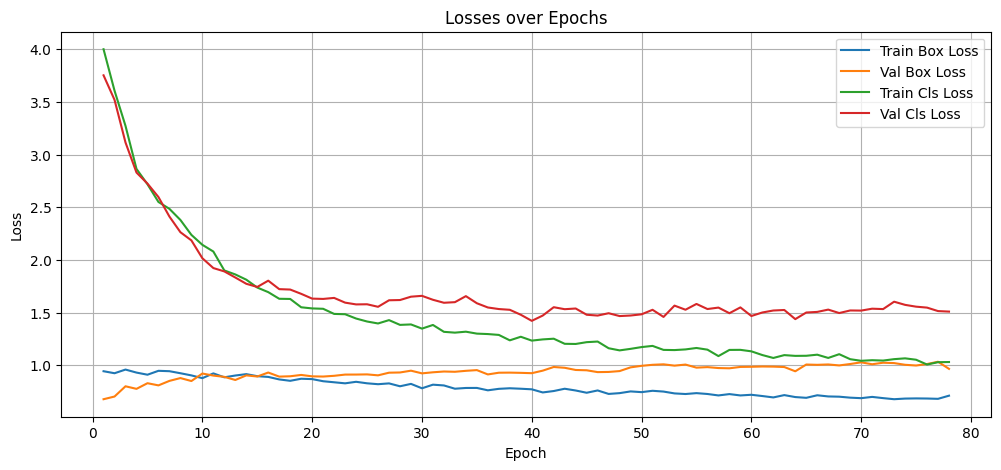

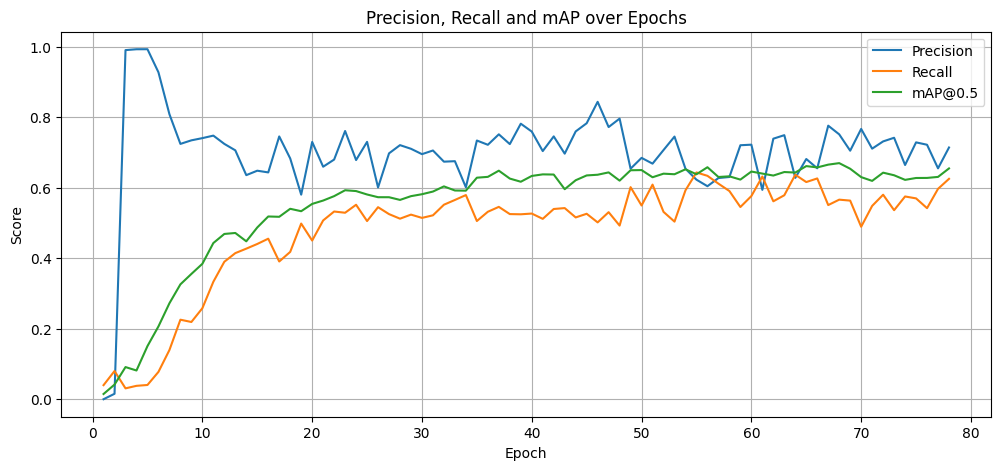

Final Precision: 0.7144
Final Recall: 0.6255
Final mAP50: 0.6550


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/runs/detect/train/results.csv')

plt.figure(figsize=(12,5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.title('Precision, Recall and mAP over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

print(f"Final Precision: {df['metrics/precision(B)'].iloc[-1]:.4f}")
print(f"Final Recall: {df['metrics/recall(B)'].iloc[-1]:.4f}")
print(f"Final mAP50: {df['metrics/mAP50(B)'].iloc[-1]:.4f}")


Saving 2008_000053.jpg to 2008_000053.jpg

image 1/1 /content/2008_000053.jpg: 480x640 1 dog, 39.2ms
Speed: 3.2ms preprocess, 39.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


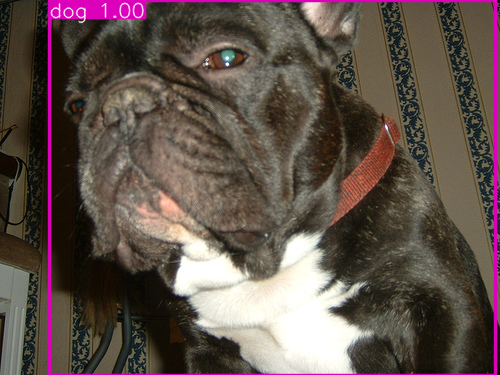

In [ ]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train/weights/best.pt")

image_path = "2008_000053.jpg"

results = model(image_path)

results[0].show()

Saving 2008_000070.jpg to 2008_000070 (1).jpg

image 1/1 /content/2008_000070.jpg: 480x640 2 chairs, 1 tvmonitor, 9.7ms
Speed: 2.5ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


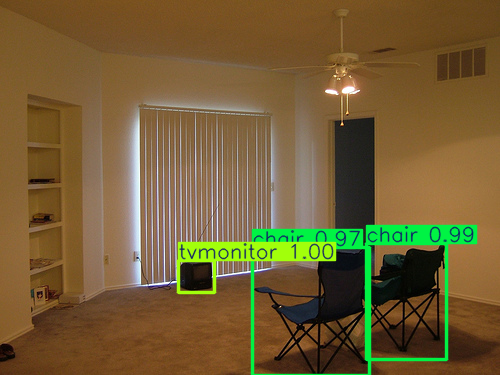

In [ ]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train/weights/best.pt")

image_path = "2008_000070.jpg"

results = model(image_path)

results[0].show()

Saving 2008_002112.jpg to 2008_002112 (1).jpg

image 1/1 /content/2008_002112.jpg: 480x640 1 bottle, 2 chairs, 2 persons, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


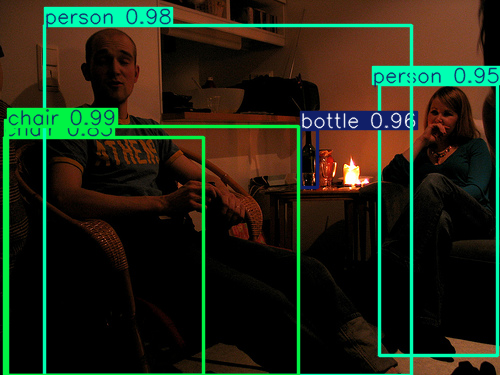

In [ ]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train/weights/best.pt")


image_path = "2008_002112.jpg"

results = model(image_path)

results[0].show()

Saving 2008_001278.jpg to 2008_001278 (2).jpg

image 1/1 /content/2008_001278.jpg: 480x640 1 horse, 3 persons, 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


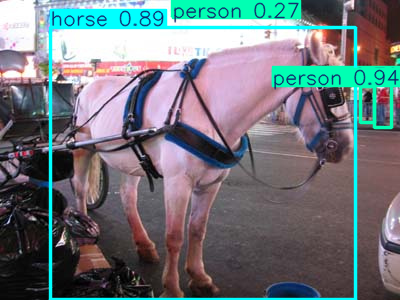

In [ ]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train/weights/best.pt")

image_path = "2008_001278.jpg"

results = model(image_path)

results[0].show()